# **Classifier Small Dataset** 

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.insert(0, "..\\Scripts")

from torchvision import transforms
from torch.utils.data import DataLoader
from ImageDatastore import ImageDatastore

## **Dataset**

In [2]:
batch_size = 512

In [ ]:
# transform = transforms.Compose(
#     [
#         transforms.Resize(
#             (232, 232), interpolation=transforms.InterpolationMode.BILINEAR
#         ),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     ]
# )
# transform = transforms.Compose(
#     [
#         transforms.Resize(
#             (232, 232), interpolation=transforms.InterpolationMode.BILINEAR
#         ),
#     ]
# )
# transform = transforms.Compose(
#     [
#         transforms.Resize(232, interpolation=transforms.InterpolationMode.BILINEAR),
#         transforms.Pad(padding=(0, 0, 0, 0), fill=0),
#         transforms.CenterCrop((232, 232)),
#         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#     ]
# )

transform = transforms.Compose(
    [
        transforms.Resize(232, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.Pad(padding=(0, 0, 0, 0), fill=0),
        transforms.CenterCrop((232, 232))
    ]
)

In [27]:
train_small = ImageDatastore('train', transform=transform)
train_small_loader = DataLoader(train_small, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count(), pin_memory=True)

In [19]:
val_small = ImageDatastore('val_set', transform=transform)
val_small_loader = DataLoader(val_small, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count(), pin_memory=True)

In [20]:
val_deg = ImageDatastore('val_degradate', transform=transform)
val_deg_loader = DataLoader(val_deg, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count(), pin_memory=True)

In [23]:
train_small.labels

,Image,Label
0,train_059371.jpg,0
1,train_059389.jpg,0
2,train_059425.jpg,0
3,train_059445.jpg,0
4,train_059516.jpg,0
...,...,...
5015,train_120127.jpg,250
5016,train_120146.jpg,250
5017,train_120161.jpg,250
5018,train_120200.jpg,250


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].


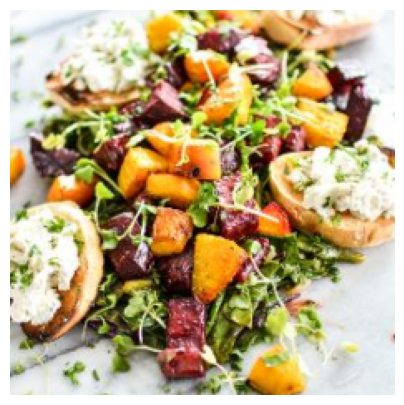

In [29]:
import matplotlib.pyplot as plt

image, label = train_small[1654]
image = image.permute(1, 2, 0)

plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.axis('off');

## **Feature extraction**

### **Hand Crafted feature extraction**

In [7]:
from BaseFeatureExtractor import BaseFeatureExtractor

In [ ]:
feature_extractor = BaseFeatureExtractor("sift", 16, (232, 232), 50)

In [60]:
paths, labels = {"train_small": [], "val_small": [], "val_deg": []}, {
    "train_small": [],
    "val_small": [],
    "val_deg": [],
}

for i, row in train_small.labels.iterrows():
    paths["train_small"].append(
        os.path.join("..", "Dataset", "train_set", row["Image"])
    )
    labels["train_small"].append(row["Label"])

for i, row in val_small.labels.iterrows():
    paths["val_small"].append(os.path.join("..", "Dataset", "val_set", row["Image"]))
    labels["val_small"].append(row["Label"])

for i, row in val_deg.labels.iterrows():
    paths["val_deg"].append(
        os.path.join("..", "Dataset", "val_set_degraded", row["Image"])
    )
    labels["val_deg"].append(row["Label"])

In [ ]:
x_train, y_train, centroids = feature_extractor.compute_features(
    paths["train_small"], labels["train_small"]
)
# x_train, y_train = feature_extractor.compute_feature_color_lbp(train_small)

x_train.shape, y_train.shape

100%|██████████| 5020/5020 [00:25<00:00, 197.51it/s]


In [ ]:
x_test, y_test = feature_extractor.compute_feature_sift_or_surf_test(
    paths["val_small"], labels["val_small"], centroids
)
# x_test, y_test = feature_extractor.compute_feature_color_lbp(val_small)
x_test.shape, y_test.shape

100%|██████████| 11994/11994 [06:23<00:00, 31.30it/s]


((11994, 16), (11994,))

In [ ]:
x_deg, y_deg = feature_extractor.compute_feature_sift_or_surf_test(
    paths["val_deg"], labels["val_deg"], centroids
)
# x_deg, y_deg = feature_extractor.compute_feature_color_lbp(val_deg)
x_deg.shape, y_deg.shape

100%|██████████| 11994/11994 [07:54<00:00, 25.28it/s]


((11994, 16), (11994,))

### **Neural Feature Extraction**

In [7]:
from NeuralFeatureExtractor import MobileNetFeatureExtractor, AlexNetFeatureExtractor, ResNetFeatureExtractor

In [8]:
feature_extractor = MobileNetFeatureExtractor()
# feature_extractor = AlexNetFeatureExtractor()
# feature_extractor = ResNetFeatureExtractor()

In [9]:
x_train, y_train = feature_extractor.compute_features(train_small_loader)
x_train.shape, y_train.shape

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [03:05<00:00, 18.57s/it]


((5020, 1280), (5020,))

In [13]:
x_test, y_test = feature_extractor.compute_features(val_small_loader)
x_test.shape, y_test.shape

100%|██████████| 24/24 [05:58<00:00, 14.94s/it]


((11994, 1280), (11994,))

In [ ]:
x_deg, y_deg = feature_extractor.compute_features(val_deg_loader)
x_deg.shape, y_deg.shape

100%|██████████| 24/24 [05:14<00:00,  8.68s/it]

In [ ]:
import numpy as np
np.save("x_train_small.npy", x_train)
np.save("y_train_small.npy", y_train)
np.save("x_val.npy", x_test)
np.save("y_val.npy", y_test)
np.save("x_val_deg.npy", x_deg)
np.save("y_val_deg.npy", y_deg)

## **Models**

### **k-NN Classifier**

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, top_k_accuracy_score

In [13]:
knn = KNeighborsClassifier(n_neighbors=51, n_jobs=-1, weights='distance', metric='cosine')

In [14]:
knn.fit(x_train, y_train)

KNeighborsClassifier(metric='cosine', n_jobs=-1, n_neighbors=51,
                     weights='distance')

In [15]:
knn_pred = knn.predict(x_test)
print(accuracy_score(y_test, knn_pred))

0.27447056861764213


In [16]:
knn_score = knn.predict_proba(x_test)
print(top_k_accuracy_score(y_test, knn_score, k=5))

0.532349508087377


In [18]:
knn_pred_deg = knn.predict(x_deg)
print(accuracy_score(y_deg, knn_pred_deg))

0.20018342504585626


In [69]:
import pandas as pd
class_name = pd.read_csv('class_list.txt', header=None)
class_name.head()

,0
0,0 macaron
1,1 beignet
2,2 cruller
3,3 cockle_food
4,4 samosa


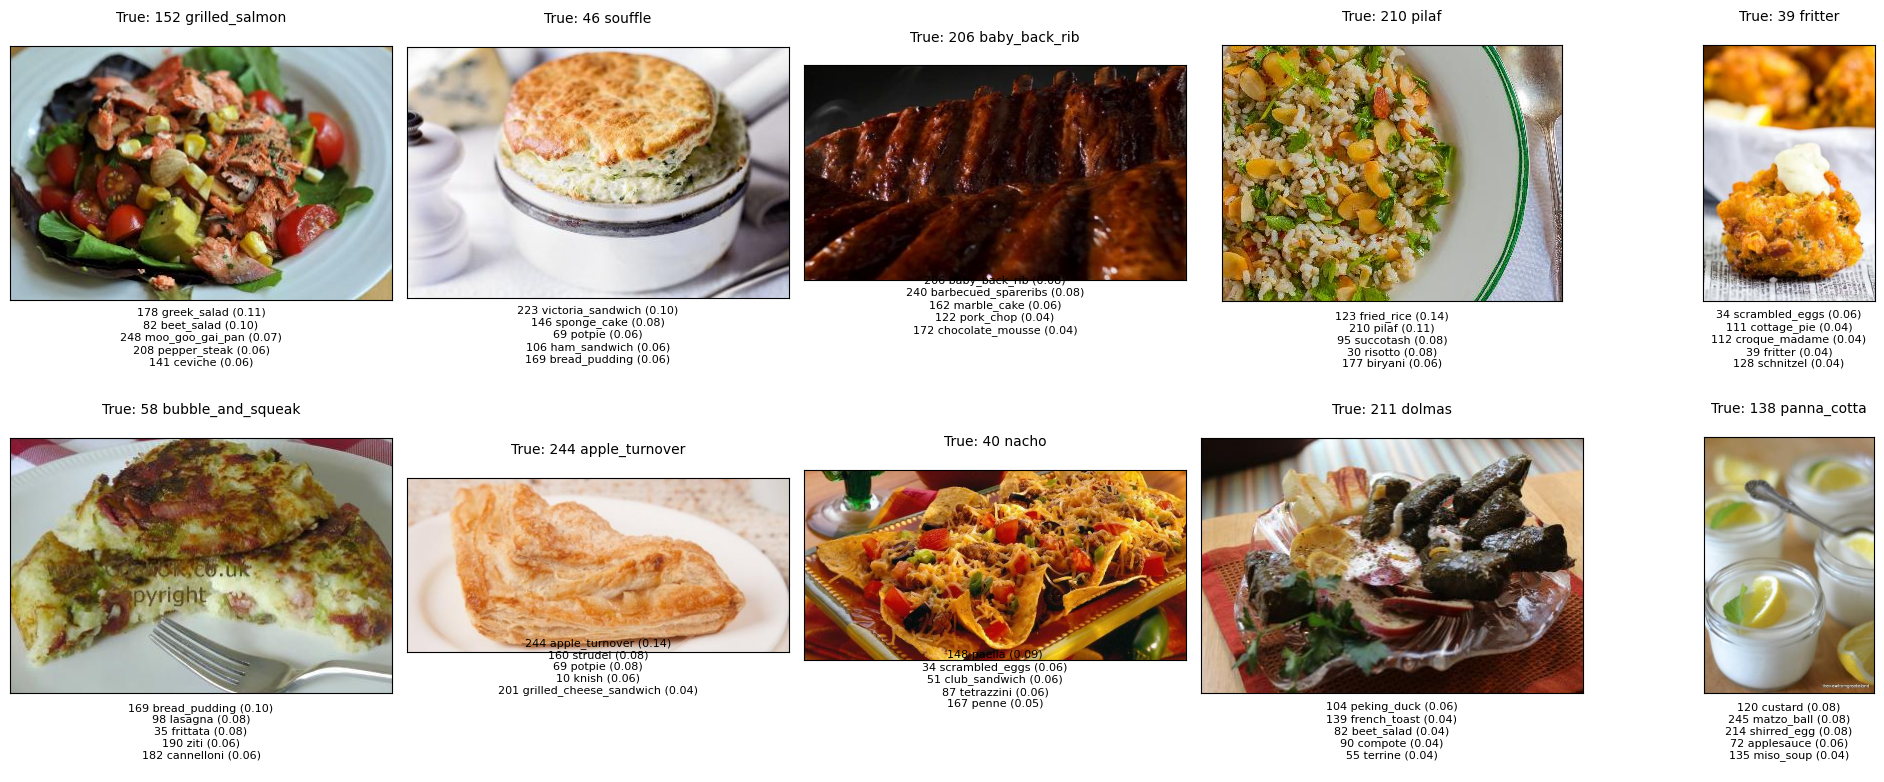

In [79]:
index = np.random.choice(range(0, len(y_test)), size=10)
df = val_small.labels

# Create a figure with 2 rows and 5 columns
fig = plt.figure(figsize=(20, 8))  # Adjust figure size as needed

for idx, i in enumerate(index):
    image = cv2.imread(os.path.join("..", "Dataset", "val_set", df.iloc[i, 0]))

    # Create subplot
    ax = plt.subplot(2, 5, idx + 1)

    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    ax.set_title("True: " + str(class_name.iloc[y_test[i], 0]) + "\n", fontsize=10)

    # Remove axis ticks
    ax.set_xticks([])
    ax.set_yticks([])

    top_5 = knn_score[i].argsort()[-5:][::-1]

    text = ""
    for j in top_5:
        text += f"{class_name.iloc[j, 0]} ({knn_score[i][j]:.2f})\n"

    # Add text under the image
    ax.text(
        0.5,
        -0.3,
        text,
        horizontalalignment="center",
        transform=ax.transAxes,
        fontsize=8,
    )

plt.tight_layout()
plt.show()

In [ ]:
knn_score_deg = knn.predict_proba(x_deg)
print(top_k_accuracy_score(y_deg, knn_score_deg, k=5))

0.4024512256128064


### **Tree Classifier**

In [20]:
from sklearn.ensemble import RandomForestClassifier

tree = RandomForestClassifier(criterion='gini', n_estimators=100, n_jobs=-1)

In [21]:
tree.fit(x_train, y_train)

RandomForestClassifier(n_jobs=-1)

In [22]:
tree_pred = tree.predict(x_test)
print(accuracy_score(y_test, tree_pred))

0.16649991662497915


In [23]:
tree_score = tree.predict_proba(x_test)
print(top_k_accuracy_score(y_test, tree_score, k=5))

0.3416708354177089


In [24]:
tree_pred_deg = tree.predict(x_deg)
print(accuracy_score(y_deg, tree_pred_deg))

0.11589127897281974


In [25]:
tree_score_deg = tree.predict_proba(x_deg)
print(top_k_accuracy_score(y_deg, tree_score_deg, k=5))

0.23870268467567116
